In [1]:
!pip install librosa
import os
import shutil
import random
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd

# ---- PART-1--SPLIT-DATA-STAGE------------------
dir_list = '/Users/meganshah/CodingAssignments_CIS4930'

# Set the path to the directory where you want to save the split datasets
split_dir = '/Users/meganshah/CodingAssignments_CIS4930/Audio_Split'

# Create the split directory if it doesn't exist
if not os.path.exists(split_dir):
    os.makedirs(split_dir)
    
    # Create separate folders for each emotion category inside the train and test folders
    for emotion in ['sad', 'angry', 'happy', 'fear']:
        os.makedirs(os.path.join(split_dir, 'train', emotion))
        os.makedirs(os.path.join(split_dir, 'test', emotion))

# Create separate lists for each emotion category
sad_list = []
angry_list = []
happy_list = []
fear_list = []

# Loop through the folders and add each audio clip to the appropriate list based on its emotion category
for folder in os.listdir(dir_list):
    if folder == 'sad':
        for filename in os.listdir(os.path.join(dir_list, folder)):
            if filename.endswith('.wav'):
                filepath = os.path.join(dir_list, folder, filename)
                sad_list.append(filepath)
    elif folder == 'angry':
        for filename in os.listdir(os.path.join(dir_list, folder)):
            if filename.endswith('.wav'):
                filepath = os.path.join(dir_list, folder, filename)
                angry_list.append(filepath)
    elif folder == 'happy':
        for filename in os.listdir(os.path.join(dir_list, folder)):
            if filename.endswith('.wav'):
                filepath = os.path.join(dir_list, folder, filename)
                happy_list.append(filepath)
    elif folder == 'fear':
        for filename in os.listdir(os.path.join(dir_list, folder)):
            if filename.endswith('.wav'):
                filepath = os.path.join(dir_list, folder, filename)
                fear_list.append(filepath)

# Shuffle each list to ensure that the samples are randomly ordered
random.shuffle(sad_list)
random.shuffle(angry_list)
random.shuffle(happy_list)
random.shuffle(fear_list)

# Select 70 samples from each list for the training set and 30 samples for the testing set
sad_train = random.sample(sad_list, 70)
angry_train = random.sample(angry_list, 70)
happy_train = random.sample(happy_list, 70)
fear_train = random.sample(fear_list, 70)

sad_test = list(set(sad_list) - set(sad_train))
angry_test = list(set(angry_list) - set(angry_train))
happy_test = list(set(happy_list) - set(happy_train))
fear_test = list(set(fear_list) - set(fear_train))

# Combine the training and testing sets for each emotion category into two separate lists
train_list = [(filepath, 'sad') for filepath in sad_train] + [(filepath, 'angry') for filepath in angry_train] + [(filepath, 'happy') for filepath in happy_train] + [(filepath, 'fear') for filepath in fear_train]
test_list = [(filepath, 'sad') for filepath in sad_test] + [(filepath, 'angry') for filepath in angry_test] + [(filepath, 'happy') for filepath in happy_test] + [(filepath, 'fear') for filepath in fear_test]

for filepath, emotion in train_list:
    filename = os.path.basename(filepath)
    shutil.copy2(filepath, os.path.join(split_dir, 'train', emotion, filename))

for filepath, emotion in test_list:
    filename = os.path.basename(filepath)
    shutil.copy2(filepath, os.path.join(split_dir, 'test', emotion, filename))


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Training set Lengths:
Sad: 70
Angry: 70
Happy: 70
Fear: 70

Testing set Lengths:
Sad: 30
Angry: 30
Happy: 30
Fear: 30

Total files: 405
Emotion distribution:
happy: 100 (24.69%)
sad: 100 (24.69%)
fear: 100 (24.69%)
angry: 100 (24.69%)
.ipynb_checkpoints: 3 (0.74%)
Audio_Split: 2 (0.49%)

---Sample Audio Clip Plots---


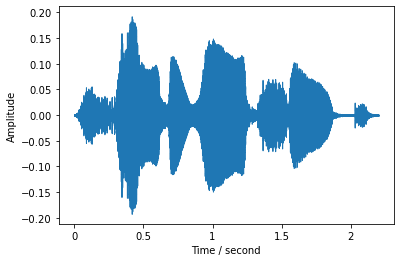

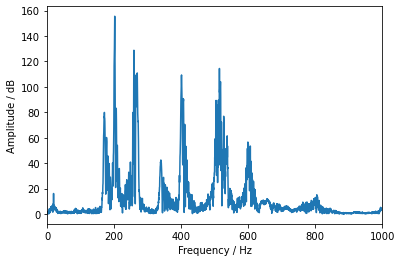

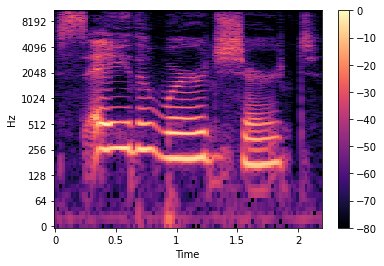

In [2]:
# ---- PART-2--EXPLORATORY-DATA-STAGE------------------
print("Training set Lengths:")
print("Sad:", len(sad_train))
print("Angry:", len(angry_train))
print("Happy:", len(happy_train))
print("Fear:", len(fear_train))
print()

print("Testing set Lengths:")
print("Sad:", len(sad_test))
print("Angry:", len(angry_test))
print("Happy:", len(happy_test))
print("Fear:", len(fear_test))
print()

emotion_counts = {}
total_files = 0

# Looking at label distributions for the split dataset
for folder in os.listdir(dir_list):
    folder_path = os.path.join(dir_list, folder)
    if os.path.isdir(folder_path):
        emotion_counts[folder] = len(os.listdir(folder_path))
        total_files += emotion_counts[folder]

print(f"Total files: {total_files}")
print("Emotion distribution:")
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count} ({round(count/total_files*100,2)}%)")
    
# Load a sample audio file using librosa
sad_clip, sr = librosa.load(sad_train[0])

# Plot the waveform and spectrogram of the audio clip
print()
print("---Sample Audio Clip Plots---")
plt.figure(1)
librosa.display.waveshow(y=sad_clip, sr=sr)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

# plot audio files in frequency domain
k = np.arange(len(sad_clip))
T = len(sad_clip)/sr
freq = k/T

DATA_0 = np.fft.fft(sad_clip)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()

# plot the time-frequency variation of the audio
D = librosa.stft(sad_clip)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [4]:
# ---PART-3---EXTRACTING-AUDIO-FEATURES----------
def extract_audio_features(folder_path, emotion):
    feature_matrix = []
    emotion_folder_path = os.path.join(folder_path, emotion)
    for file in os.listdir(emotion_folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(emotion_folder_path, file)
            signal, sample_rate = librosa.load(file_path, sr=None)
            
            # audio feature extraction: loudness
            df_loudness = pd.DataFrame()
            S, phase = librosa.magphase(librosa.stft(signal))
            rms = librosa.feature.rms(S=S)
            df_loudness['Loudness'] = rms[0][:12]  # keep only the first 12 values
            
            # audio feature extraction: mel-frequency cepstral coefficients
            df_mfccs = pd.DataFrame()
            mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)
            for n_mfcc in range(len(mfccs)):
                df_mfccs[f'MFCC_{n_mfcc+1}'] = mfccs.T[n_mfcc]
            
            # audio feature extraction: zero crossing rate
            df_zero_crossing_rate = pd.DataFrame()
            zcr = librosa.feature.zero_crossing_rate(y=signal)
            df_zero_crossing_rate['ZCR'] = zcr[0][:12]  # keep only the first 12 values
            
            # audio feature extraction: chroma
            df_chroma = pd.DataFrame()
            chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
            for n_chroma in range(len(chromagram)):
                df_chroma[f'Chroma_{n_chroma+1}'] = chromagram.T[n_chroma]
            
            # audio feature extraction: mel spectrogram
            df_mel_spectrogram = pd.DataFrame()
            mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12)
            for n_mel in range(len(mel_spectrogram)):
                df_mel_spectrogram[f'Mel_Spectrogram_{n_mel+1}'] = mel_spectrogram.T[n_mel]
            
            # combine all features and append in matrix
            feature_vector = pd.concat([df_loudness, df_mfccs, df_zero_crossing_rate, df_chroma, df_mel_spectrogram], axis=1)
            feature_matrix.append(feature_vector)
    
    return feature_matrix

In [5]:
# Generate feature matrices for emotions in training and testing data
train_folder ='/Users/meganshah/CodingAssignments_CIS4930/Audio_Split/train' 
test_folder = '/Users/meganshah/CodingAssignments_CIS4930/Audio_Split/test'

anger_train = extract_audio_features(train_folder, "angry")
fear_train = extract_audio_features(train_folder, "fear")
happy_train = extract_audio_features(train_folder, "happy")
sad_train = extract_audio_features(train_folder, "sad")

anger_test = extract_audio_features(test_folder, "angry")
fear_test = extract_audio_features(test_folder, "fear")
happy_test = extract_audio_features(test_folder, "happy")
sad_test = extract_audio_features(test_folder, "sad")

print(anger_train)


[    Loudness      MFCC_1      MFCC_2      MFCC_3      MFCC_4      MFCC_5  \
0   0.000871 -484.358124 -390.698364 -356.173096 -359.804749 -371.713745   
1   0.003886  -18.398375  -61.479107 -102.925323 -119.267136 -116.789520   
2   0.011530    7.087003   18.751526   37.909309   49.971947   49.942749   
3   0.015015   22.018394    9.614942    2.872880   -4.260642  -23.614941   
4   0.014737  -18.821033  -26.494694  -24.774837  -15.003356   -2.828177   
5   0.014187   23.995304   20.775761   18.513180   13.651355    5.700620   
6   0.017920   -8.672148  -13.216332  -13.369032   -7.360594   -2.703953   
7   0.023100    2.731507    8.159767   12.020668   12.810236   10.169991   
8   0.024176   -0.538606    0.673415   -1.789495    0.398657    4.164205   
9   0.022633    2.142439    1.808418    3.358118    7.810452   12.176654   
10  0.020904   -3.043422    0.267316    1.199844    1.460788    4.315367   
11  0.018898   15.026031   15.565304   20.803011   15.545732    7.801117   

        MF

In [6]:
# ---PART-4---SCALING-AND-AVERAGING-AUDIO-FEATURES----------
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def scale_feature_matrix(feature_matrix):
    scaler = StandardScaler()
    feature_matrix_2d = np.vstack(feature_matrix)
    feature_matrix_2d_scaled = scaler.fit_transform(feature_matrix_2d)
    return feature_matrix_2d_scaled

# Scales and averages feature matrix given training array of arrays by reshaping
def scale_min_max_train(feature_matrix):
    feature_matrix = np.array(feature_matrix)
    feature_matrix = feature_matrix.reshape(70, -1)
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    avg_feature_matrix = np.mean(feature_matrix_scaled.reshape(70, 12, 38), axis=1)
    return avg_feature_matrix

# Scales and averages feature matrix given testing array of arrays by reshaping
def scale_min_max_test(feature_matrix):
    feature_matrix = np.array(feature_matrix)
    feature_matrix = feature_matrix.reshape(30, -1)
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    avg_feature_matrix = np.mean(feature_matrix_scaled.reshape(30, 12, 38), axis=1)
    return avg_feature_matrix

#create train and test arrays
train_emotion_features = []
test_emotion_features = []
print(np.array(anger_train).shape)

# Scale and average training data
anger_train_scaled = scale_min_max_train(anger_train)
fear_train_scaled = scale_min_max_train(fear_train)
happy_train_scaled = scale_min_max_train(happy_train)
sad_train_scaled = scale_min_max_train(sad_train)

# Append results into training list
train_emotion_features.extend(anger_train_scaled)
train_emotion_features.extend(fear_train_scaled)
train_emotion_features.extend(happy_train_scaled)
train_emotion_features.extend(sad_train_scaled)

# Scale and average testing data
anger_test_scaled = scale_min_max_test(anger_test)
fear_test_scaled = scale_min_max_test(fear_test)
happy_test_scaled = scale_min_max_test(happy_test)
sad_test_scaled = scale_min_max_test(sad_test)

# Append results into a testing list
test_emotion_features.extend(anger_test_scaled)
test_emotion_features.extend(fear_test_scaled)
test_emotion_features.extend(happy_test_scaled)
test_emotion_features.extend(sad_test_scaled)

print(train_emotion_features)

(70, 12, 38)
[array([-0.28265888, -0.05739328, -0.00703761,  0.0264305 ,  0.08490171,
       -0.04034794, -0.09010494, -0.06219044, -0.01953521, -0.00649703,
        0.05510352,  0.04604344,  0.0975809 ,  0.2699193 ,  0.346287  ,
        0.46500708, -0.30154164, -0.39921328, -0.25305137,  0.35074296,
       -0.39498838, -0.38293432, -0.10796665,  0.16712513,  0.08559459,
        0.07942492, -0.62632286, -0.59465714, -0.49561221, -0.67678954,
       -0.85064388, -0.85210603, -0.71024688, -0.36360518, -0.44416087,
       -0.80193024, -0.84715225, -0.82179597]), array([-0.35013625,  0.04315464,  0.1667898 , -0.03994246, -0.09690822,
       -0.15606749,  0.01136248, -0.11759954, -0.09851414, -0.18436473,
       -0.08833183,  0.08706996,  0.0707242 ,  0.58762185,  0.2226956 ,
       -0.1833324 , -0.15210237, -0.13322141, -0.23120244, -0.02495185,
       -0.15652815, -0.11581934, -0.1403058 ,  0.10179066,  0.00555146,
       -0.03534353, -0.67149875, -0.80116687, -0.87494895, -0.7688387 ,
  


Model Performance with Random Forrest Classifier:
Accuracy: 0.6
Precision: 0.5975430216580514
Recall: 0.6
F1-Score: 0.5974442925614257

Random Forrest Classification Report
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        30
           1       0.50      0.43      0.46        30
           2       0.72      0.70      0.71        30
           3       0.62      0.70      0.66        30

    accuracy                           0.60       120
   macro avg       0.60      0.60      0.60       120
weighted avg       0.60      0.60      0.60       120

Confusion Matrix


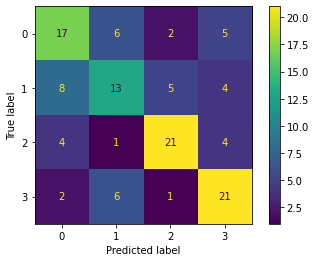

In [7]:
# -----PART-5-BUILDING-RECOGNITION-MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create X train, X test, Y train, and Y test
X_train = train_emotion_features
X_test = test_emotion_features

y_train = [0 for i in range(70)] + [1 for i in range(70)] + [2 for i in range(70)] + [3 for i in range(70)]
y_test = [0 for i in range(30)] + [1 for i in range(30)] + [2 for i in range(30)] + [3 for i in range(30)]

# Building Random For
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Test classifier on testing set
rf_y_pred = rf.predict(X_test)
rf_y_pred_proba = rf.predict_proba(X_test)

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred, average='weighted', pos_label=1)
rf_recall = recall_score(y_test, rf_y_pred, average='weighted', pos_label=1)
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted', pos_label=1)

# Print model evaluation and metrics
print()
print('Model Performance with Random Forrest Classifier:')
print('Accuracy:', rf_accuracy)
print('Precision:', rf_precision)
print('Recall:', rf_recall)
print('F1-Score:', rf_f1)
print()

print("Random Forrest Classification Report")
print(classification_report(y_test, rf_y_pred))

#evaluating the classification model with confusion matrix and ROC
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay, roc_curve, auc, r2_score

cmr = confusion_matrix(y_test, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cmr, display_labels=rf.classes_)
disp.plot()
print("Confusion Matrix")
plt.show()



Support Vector Machine Model Performance:
Accuracy: 0.5833333333333334
Precision: 0.5846096379055055
Recall: 0.5833333333333334
F1-Score: 0.577689719755827

SVC Classification Report
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        30
           1       0.44      0.37      0.40        30
           2       0.68      0.77      0.72        30
           3       0.70      0.53      0.60        30

    accuracy                           0.58       120
   macro avg       0.58      0.58      0.58       120
weighted avg       0.58      0.58      0.58       120

Confusion Matrix


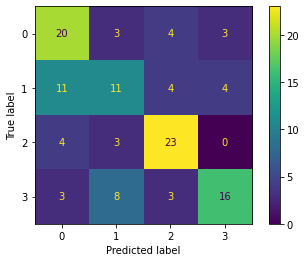

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Build model and fit on data
svc = SVC(kernel='rbf', gamma='scale', random_state=42, probability=True)
svc.fit(X_train, y_train)

# Test classifier on testing set
svc_y_pred = svc.predict(X_test)
svc_y_pred_proba = svc.predict_proba(X_test)

# Calculate performance metrics
svc_accuracy = accuracy_score(y_test, svc_y_pred)
svc_precision = precision_score(y_test, svc_y_pred, average='weighted', pos_label=1)
svc_recall = recall_score(y_test, svc_y_pred, average='weighted', pos_label=1)
svc_f1 = f1_score(y_test, svc_y_pred, average='weighted', pos_label=1)

# Print SVM model performance and evaluation metrics
print()
print('Support Vector Machine Model Performance:')
print('Accuracy:', svc_accuracy)
print('Precision:', svc_precision)
print('Recall:', svc_recall)
print('F1-Score:', svc_f1)
print()

from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay, roc_curve, auc, r2_score

print("SVC Classification Report")
print(classification_report(y_test, svc_y_pred))

# Evaluating the classification model with confusion matrix and ROC
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay, roc_curve, auc, r2_score

cmr = confusion_matrix(y_test, svc_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cmr)
disp.plot()
print("Confusion Matrix")
plt.show()




GBC Model Performance:
Accuracy: 0.55
Precision: 0.5426382047071703
Recall: 0.55
F1-Score: 0.5448980992245934

GBC Classification Report
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        30
           1       0.38      0.37      0.37        30
           2       0.69      0.67      0.68        30
           3       0.66      0.77      0.71        30

    accuracy                           0.55       120
   macro avg       0.54      0.55      0.54       120
weighted avg       0.54      0.55      0.54       120


Confusion Matrix


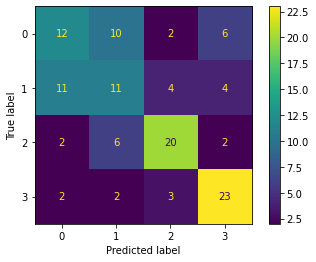

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model and fit data
gbc = GradientBoostingClassifier(n_estimators=100, random_state=28)
gbc.fit(X_train, y_train)
gbc_y_pred = gbc.predict(X_test)

# Performs calculations and evaluates model metics
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_precision = precision_score(y_test, gbc_y_pred, average='weighted', pos_label=1)
gbc_recall = recall_score(y_test, gbc_y_pred, average='weighted', pos_label=1)
gbc_f1 = f1_score(y_test, gbc_y_pred, average='weighted', pos_label=1)

# Print GBC model performance
print()
print('GBC Model Performance:')
print('Accuracy:', gbc_accuracy)
print('Precision:', gbc_precision)
print('Recall:', gbc_recall)
print('F1-Score:', gbc_f1)
print()
print("GBC Classification Report")
class_report = classification_report(y_test, gbc_y_pred)
print(class_report)
print()
print("Confusion Matrix")
cms = confusion_matrix(y_test, gbc_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cms)
disp.plot()
plt.show()



In [ ]:
# PART 6 is shown in the attached Google Doc report-- thank you for a great semester :)